### PASO 6 - Creación de fórmula

In [1]:
def analysis_industria(industria):
    
    import pandas as pd
    import numpy as np
    import os
    from scipy.stats.stats import pearsonr
    import statsmodels
    import seaborn as sns
    import statsmodels.formula.api as smf
    from sklearn.feature_selection import RFE
    from sklearn.svm import SVR
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import LogisticRegression
    import matplotlib.pyplot as plt
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    import warnings
    warnings.filterwarnings('ignore') 

    #Leemos el archivo excel de la industria 'Healthcare'.
    ruta = "C:/Users/carlos.guisado/Documents/Master/Master Kschool/TFM/Industrias/"
    df = pd.read_excel(ruta + industria)
    punto = industria.index('.')
    nombre_industria = industria[:punto]
    print()
    print("Vamos a analizar la industria: " + nombre_industria + ".")
    
    #Borramos aquellas columnas de las cuales no tenemos ningún dato. 
    #Esto lo hacemos porque en el dataset vienen variables financieras las cuales no se estudian en todas las industrias.
    df = df.dropna(axis = 1, how ="all")
    df = df.dropna(axis = 1, how ="all")
    df = df.drop(['TRBC Industry Group'], axis = 1)
    
    
    #Empresas que vamos a analizar
    df_groupby = df.groupby("Company Name")
    print("En esta industria, analizaremos un total de " + str(len(df_groupby)) + " empresas que cotizan en el mercado bursátil.")
    print()
    
    #Dimensiones y ratios a analizar:
    df_ = df
    #Limpieza de datos de los Ratios
    df = df.drop(['Company Name','Field Name'], axis = 1)
    df = df.dropna(axis = 0, how = "all")
    Ratios = df
    #Limpieza de datos de los Ratios
    print("El dataset en cuestión tiene unas dimensiones de: " + str(df_.shape) + " , ya que contamos con el histórico financiero de las empresas a analizar.") 
    print()
    print("El número total de Ratios a analizar en esta industria es de :" + str(df_.shape[1]))
    print()
    
    #Análisis Industria del año 2019:
    #Guardamos la variable final para estudiarla junto con la empresa que queramos
    #Reemplazamos los valores nulos por la media del total del año 2019
    df_analysis_2019 = df_
    df_analysis_2019 = df_analysis_2019[df_analysis_2019["Field Name"].str.contains("2019")]
    #CDefinimos variable con una lista de las columnas
    col = df_analysis_2019.columns.values.tolist()
    #Definimos los filtros que no queremos en el dataset
    df_analysis_2019 = df_analysis_2019.drop(['Company Name','Field Name'], axis = 1)
    #Reemplazamos valores nulos por la media
    cols = df_analysis_2019.columns.tolist()
    for i in cols:
        df_analysis_2019[i] = df_analysis_2019[i].fillna(df_analysis_2019[i].mean())
    df_analysis_2019 = df_analysis_2019.describe()
    df_analysis_2019 = df_analysis_2019[1:]
    df_2019_industria = pd.DataFrame(df_analysis_2019.iloc[0])
    df_2019_industria = df_2019_industria.transpose().rename(index={'mean': "2019"})
    df_2019_industria
    
    #Análisis Industria
    #Reemplazamos los valores nulos por la media del total y sacamos graficos de cómo ha ido evolucionando cada ratio.
    df_analysis = df_
    df_rt = pd.DataFrame()
    for i in range (2010,2020):
        df_analysis = df_[df_["Field Name"].str.endswith(str(i))]
        col = df_analysis.columns.values.tolist()
        df_analysis = df_analysis.drop(['Company Name','Field Name'], axis = 1)
        cols = df_analysis.columns.tolist()
        #Se reemplazan los valores nulos por la media
        for x in cols:
            df_analysis[x] = df_analysis[x].fillna(df_analysis[x].mean())
        #Calculamos el porcentaje de valores nulos por columna, y borramos aquellas columnas con más de un 12%
        total = df_analysis.isnull().sum().sort_values(ascending = False)
        percent = (df_analysis.isnull().sum() / df_analysis.isnull().count()).sort_values(ascending = False)
        missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
        df_analysis = df_analysis.drop((missing_data[missing_data['Percent'] > 0.12]).index,1)
        #Se sacan los datos estadísticos
        df_analysis = pd.DataFrame(df_analysis.describe())
        df_analysis = df_analysis[1:]
        df_analysis = pd.DataFrame(df_analysis.iloc[0])
        df_analysis = df_analysis.transpose().rename(index={'mean': i})

        #Cambiar mean por la i
        df_rt = pd.concat([df_rt, df_analysis], axis = 0)
    
    df_rt
    
    #Representación gráfica con plots
    print("Ahora vamos a ver, en forma gráfica, como han ido evolucionando la media de estos ratios a lo largo de los últimos años.")
    print()       
    cols = df_rt.columns.values.tolist()
    for i in range(0,len(df_rt.columns)):
        df_rt[cols[i]].plot()
        plt.xlabel("Años")
        plt.ylabel("Valor Medio")
        plt.title(str(df_rt[cols[i]].name))
        print(plt.show())
    
    #VIF
    #Calcularemos el Factor de Inflación de Varianza para cada una de los ratios, con el fin de eliminar de nuestra ecuación
    #aquellos que ofrezcan la misma información, con el objetivo de crear un modelo acertado.
    corr = Ratios.corr()
    Ratios_vif = Ratios
    cols = Ratios_vif.columns.tolist()
    for i in cols:
        Ratios_vif[i] = Ratios_vif[i].fillna(Ratios_vif[i].mean())

    def calculate_vif(Ratios_vif):
        vif = pd.DataFrame()
        vif["Ratios"] = Ratios_vif.columns
        vif["VIF"] = [variance_inflation_factor(Ratios_vif.values, i) for i in range(Ratios_vif.shape[1])]    
        return(vif)
    vif = calculate_vif(Ratios_vif)
    while vif['VIF'][vif['VIF'] > 7].any():
        remove = vif.sort_values('VIF',ascending=0)['Ratios'][:1]
        Ratios_vif.drop(remove,axis=1,inplace=True)
        vif = calculate_vif(Ratios_vif)
    vif
    

    data = corr[['Market Capitalization']].sort_values(by = 'Market Capitalization',ascending = False)
    data_corr = data["Market Capitalization"]
    data_corr= data_corr.to_frame()
    data_corr["Distance"] = data_corr["Market Capitalization"]
    for i in range(0,len(data_corr)):
        if data_corr["Distance"][i] <0:
            data_corr["Distance"][i] = abs(data_corr["Distance"][i])
            
    data_ = data_corr.sort_values("Distance", ascending = False)
    data_ = data_.iloc[0:10]
    
    #Análisis de la correlación de los ratios
    ratios = corr
    Ratios_corr = ratios[[data_.iloc[0].name, data_.iloc[1].name, data_.iloc[2].name, data_.iloc[3].name, data_.iloc[4].name, data_.iloc[5].name, data_.iloc[6].name, data_.iloc[7].name]]
    filas = Ratios_corr.index.values
    columnas = Ratios_corr.columns.values
    result = [columnas for columnas in columnas if columnas in filas]
    Ratios_corr[result].loc[result]
    
    # Matriz de correlación
    corrmat = Ratios_corr.corr()
    k = 8 # Número de variables.
    cols = corrmat.nlargest(k, 'Market Capitalization')['Market Capitalization'].index
    cm = np.corrcoef(Ratios_corr[cols].values.T)
    sns.set(font_scale = 1)
    hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f', annot_kws = {'size': 12}, yticklabels = cols.values, xticklabels = cols.values)
    print("La matriz de correlación entre las variables es la siguiente: ")
    print()
    print(plt.show())
    
    lista = []
    for i in range(1,len(data_)):
        lista.append(data_.iloc[i].name)
    print("Las variables financieras con mayor correlación con respecto a la varianza en su cotización en la industria " + nombre_industria  + " son las siguientes: ")
    print()
    for x in lista:
        print(x)
    
    
    print()
    print("Los ratios financieros de esta industria han sufrido los siguientes cambios en el último año: ")
    print()
    print(df_2019_industria.transpose())

In [5]:
#Creamos un diccionario con el nombre de las industrias y cómo se llama su documento.
diccionario = {'Healthcare Equipment & Supplies' : 'Healthcare.xlsx', 'Metals & Mining' : 'Metals_Mining.xlsx', 'Passenger Transportation Services': 'Passenger_Transportation_Services.xlsx',
               'Specialty Retailers' : 'Specialty_Retailers.xlsx',  'Computers, Phones & Household Electronics' : 'Computers_Phones_Household_Electronics.xlsx',
               'Freight & Logistics Services' : 'Freight_Logistics_Services.xlsx' , 'Pharmaceuticals' : 'Pharmaceuticals.xlsx',
               'Professional & Commercial Services' : 'Professional_Commercial_Services.xlsx', 'Food & Tobacco' : 'Food_Tobacco.xlsx' , 
               'Software & IT Services' : 'Software_IT_Services.xlsx' , 'Multiline Utilities' : 'Multiline_Utilities.xlsx', 'Electric Utilities & IPPs' :'Electric_Utilities_IPPs.xlsx',
               'Insurance' : 'Insurance.xlsx' , 'Machinery, Tools, Heavy Vehicles, Trains & Ships' : 'Machinery.xlsx' , 'Chemicals' : 'Chemicals.xlsx' , 
               'Residential & Commercial REITs' : 'Residential_Commercial_REITs.xlsx', 'Aerospace & Defense' : 'Aerospace_Defense.xlsx' , 
               'Investment Banking & Investment Services' : 'Investment_Banking_Investment_Services.xlsx', 'Communications & Networking' : 'Communications.xlsx' ,
               'Semiconductors & Semiconductor Equipment' : 'Semiconductors.xlsx', 'Diversified Retail' : 'Diversified_Retail.xlsx' , 'Specialty Retailers' : 'Specialty_Retailers.xlsx' , 
               'Healthcare Providers & Services': 'Healthcare_Providers_Services.xlsx' , 'Oil & Gas' : 'Oil_Gas.xlsx' , 'Electronic Equipment & Parts' : 'Electronic_Equipment_Parts.xlsx' ,
               'Containers & Packaging' : 'Containers_Packaging.xlsx' , 'Water & Related Utilities' : 'Water_Related_Utilities.xlsx', 'Banking Services':'Banking_Services.xlsx', 'Homebuilding & Construction Supplies' : 'Homebuilding_Construction_Supplies.xlsx',
               'Leisure Products' : 'Leisure_Products.xlsx' , 'Textiles & Apparel' : 'Textiles_Apparel.xlsx' , 'Beverages':'Beverages.xlsx', 'Coal' : "Coal.xlsx" , 
               'Automobiles & Auto Parts' : 'Automobiles_Auto_Parts.xlsx' , 'Food & Drug Retailing' : 'Food_Drug_Retailing.xlsx' , 'Media & Publishing' : 'Media_Publishing.xlsx' , 
               'Hotels & Entertainment Services' : 'Hotels_Entertainment_Services.xlsx' , 'Personal & Household Products & Services' : 'Personal_Household_PS.xlsx' , 
               'Freight & Logistics Services' : 'Freight_Logistics_Services.xlsx', 'Telecommunications Services' : 'Telecommunications_Services.xlsx' , 
               'Oil & Gas Related Equipment and Services' : 'Oil_Gas_Equipment_Services.xlsx' , 'Industrial Conglomerates' : 'Industrial_Conglomerates.xlsx' , 
               'Biotechnology & Medical Research' : 'Biotechnology_Medical_Research.xlsx' , 'Diversified Industrial Goods Wholesalers': 'Diversified_Industrial_Goods.xlsx',
               'Real Estate Operations' : 'Real_Estate_Operations.xlsx' , 'Construction & Engineering' : 'Construction_Engineering.xlsx', 'Paper & Forest Products Goods': 'Paper_Forest_Products.xlsx',
               'Construction Materials' : 'Construction_Materials.xlsx' , 'Household Goods': 'Household_Goods.xlsx', 'Natural Gas Utilities' : 'Natural_Gas_Utilities.xlsx',
               'Office Equipment' : 'Office_Equipment.xlsx'}

In [6]:
#Fórmula análisis empresa
def analysis_empresa(empresa):
    import pandas as pd
    import numpy as np
    import os
    from scipy.stats.stats import pearsonr
    import statsmodels
    import seaborn as sns
    import statsmodels.formula.api as smf
    from sklearn.feature_selection import RFE
    from sklearn.svm import SVR
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import LogisticRegression
    import matplotlib.pyplot as plt
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    import warnings
    warnings.filterwarnings('ignore') 
    
    #Cargamos los datos de nuestro Dataset
    df = pd.read_excel('Ratios.xlsx')
    
    #Borramos aquellas columnas que no tengan ningún dato
    df = df.dropna(axis = 1, how = "all")

    #Creamos variable con todos los nombres de las empresas que vamos a analizar
    lista_empresas = df["Company Name"].unique().tolist()

    #Creamos un nuevo df con los datos de la empresa que queremos buscar.
    df_analysis_empresa = df[df["Company Name"].str.contains(empresa)]
    industria_empresa = df_analysis_empresa["TRBC Industry Group"].iloc[0]
    industria_empresa = diccionario[industria_empresa]

    #Llamamos a otra función para sacar los datos de la industria a la que pertenece la empresa que queremos analizar
    print("ANÁLISIS DE LA EMPRESA : " + empresa)
    print()
    print("Antes de comenzar a examinar la empresa es cuestión, tenemos que analizar su entorno, con el fin de conocer cuáles son los ratios con mayor relevancia dentro de la industria a la que pertenece y hacer una compración con la media de mercado.")
    print()
    analysis_industria(industria_empresa)
    

    #print("Una vez analizada la industria a la que pertenece la empresa " + str(empresa) + ", ahora vamos a analizar sus ratios financieros.")
    
    #Filtramos por aquellas que unicamente reportan en millones
    df_analysis_empresa = df_analysis_empresa.dropna(axis = 1, how = "all")
    df_analysis_empresa = df_analysis_empresa.dropna(axis = 0, how = "all")
    df_analysis_empresa = df_analysis_empresa.drop(["Company Name", 'TRBC Industry Group'], axis = 1 )

    #Análisis Empresa en el año 2019:
    #Reemplazamos los valores nulos por la media del total del año 2019
    df_analysis_e2019 = df_analysis_empresa
    df_analysis_e2019 = df_analysis_e2019[df_analysis_e2019["Field Name"].str.contains("2019")]
    #CDefinimos variable con una lista de las columnas
    col = df_analysis_e2019.columns.values.tolist()
    #Definimos los filtros que no queremos en el dataset
    df_analysis_e2019 = df_analysis_e2019.drop(['Field Name'], axis = 1)
    #Reemplazamos valores nulos por la media
    cols = df_analysis_e2019.columns.tolist()
    #for i in cols:
    #    df_analysis_e2019[i] = df_analysis_e2019[i].fillna(df_analysis_e2019[i].mean())
    df_analysis_e2019 = df_analysis_e2019.describe()
    df_analysis_e2019 = df_analysis_e2019[1:]
    df_2019_empresa = pd.DataFrame(df_analysis_e2019.iloc[0])
    df_2019_empresa = df_2019_empresa.transpose().rename(index={'mean': "2019"})
    df_2019_empresa

    print()
    print("Y estos son los cambios que han sufrido los ratios financieros de " + str(empresa) + " en el último año.")
    print()
    print(df_2019_empresa.transpose())
    #Tenemos el nombre de la industria, por lo que vamos a pasarle los modelos predictivos de su industria.
    #Primero los calculamos

    ruta = "C:/Users/carlos.guisado/Documents/Master/Master Kschool/TFM/Industrias/"
    df = pd.read_excel(ruta + "Healthcare.xlsx") #sustituir por var: industria_empresa
    df_ = df
    df

    #Limpieza de datos
    df = df.drop(['Company Name', 'Field Name', 'TRBC Industry Group'], axis = 1)
    df = df.dropna(axis = 0, how= "all")
    Ratios = df
    total = Ratios.isnull().sum().sort_values(ascending = False)
    percent = (Ratios.isnull().sum() / Ratios.isnull().count()).sort_values(ascending = False)
    missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    Ratios = Ratios.drop((missing_data[missing_data['Percent'] > 0.15]).index,1)
    cols = Ratios.columns.tolist()
    #Se reemplazan los valores nulos por la media
    for x in cols:
        Ratios[x] = Ratios[x].fillna(Ratios[x].mean())
    lista = Ratios.columns.values.tolist()
    for i in lista:
        Ratios[i].replace(np.inf,0,inplace=True)
        Ratios[i].replace(-np.inf,0,inplace=True)
    Ratios_vif = Ratios
    df_modelo = Ratios

    #Le pasamos VIF para quedarnos con los ratios con mayor correlación
    #Calcularemos el Factor de Inflación de Varianza para cada una de los ratios, con el fin de eliminar de nuestra ecuación
    #aquellos que ofrezcan la misma información, con el objetivo de crear un modelo acertado.

    def calculate_vif(kschool):
        vif = pd.DataFrame()
        vif["Ratios"] = Ratios_vif.columns
        vif["VIF"] = [variance_inflation_factor(Ratios_vif.values, i) for i in range(Ratios_vif.shape[1])]    
        return(vif)
    vif = calculate_vif(Ratios_vif)
    while vif['VIF'][vif['VIF'] > 7].any():
        remove = vif.sort_values('VIF',ascending=0)['Ratios'][:1]
        Ratios_vif.drop(remove,axis=1,inplace=True)
        vif = calculate_vif(Ratios_vif)
    vif

    print("Ya que los ratios financieros de la empresa no son independientes entre sí, hemos tenido que ajustarlos y eliminar aquellos en los que la correlación era muy alta.")
    print("Este ajuste se ha hecho a través del cálculo d Factor de inflación de la varianza.")
    print()
    print("Tras el ajuste, el número total de ratios financieros son " + str(len(vif)) + ".")
    
    lista_vif = vif['Ratios'].values.tolist()
    print()
    print("Las variables con una mayor correlación entre la varianza del Market Value y sus ratios financieros son: ")
    print()
    for x in lista_vif:
        print(x)
    print()    
    
    
    #Definimos el df que vamos a utilizar para las Regresiones Múltiple y Polinomial
    Ratios_modelo = df[["Market Capitalization"]]
    for i in lista_vif:
        Ratios_modelo = pd.concat([Ratios_modelo, pd.DataFrame(Ratios[i])], axis = 1)
    cols = Ratios_modelo.columns.tolist()
    #Se reemplazan los valores nulos por la media
    for x in cols:
        Ratios_modelo[x] = Ratios_modelo[x].fillna(Ratios_modelo[x].mean())
    lista = Ratios_modelo.columns.values.tolist()
    for i in lista:
        Ratios_modelo[i].replace(np.inf,0,inplace=True)
        Ratios_modelo[i].replace(-np.inf,0,inplace=True)
    print()    
    print("Ahora comenzamos con el análisis de los modelos predictivos, de los cuales obtendremos sus coeficientes, puntos de intersección y puntuación")
    print()    
    #Regresión Múltiple con Scikit - learn
    data = Ratios_modelo
    feature_cols = data.columns[1:]
    X = data[feature_cols]
    y = data["Market Capitalization"]

    estimator = SVR(kernel ='linear')
    selector = RFE(estimator, 6, step = 1)
    selector= selector.fit(X,y)
    selector.ranking_

    lista = []
    for i in range(0,len(selector.ranking_)):
        if selector.ranking_[i] == 1:
            lista.append(i)

    X_pred = X[X.columns[lista]]
    nom_vars = X[X.columns[lista]]

    lm = LinearRegression()
    lm.fit(X_pred,y)
    
    print()    
    print("Aplicamos un modelo de regresión Múltiple")
    print()
    print ("Las variables con mayor correlación con la varianza en el precio de mercado son las siguientes: " + str(nom_vars.columns.values.tolist()))
    print()
    print ( "El punto de intersección es el " + str(lm.intercept_))
    print()
    print("Los coeficientes de cada una de las variables son " + str(lm.coef_))
    print()
    print("La puntuación de este modelo es de " + str(lm.score(X_pred,y)))
    
    
    #Regresión Polinomial
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures

    #Definimos las variables
    data = Ratios_modelo
    feature_cols = data.columns[1:]
    x = data[feature_cols]
    y = data["Market Capitalization"]

    for i in range(1,100):

        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = i)
        poli_reg = PolynomialFeatures(degree = 2)

        #Transformamos las características existentes en características de mayor grado
        X_train_poli = poli_reg.fit_transform(X_train)
        X_test_poli = poli_reg.fit_transform(X_test)

        #Definimos el algoritmo a utilizar
        pr = LinearRegression()

        #Entrenamos del modelo
        pr.fit(X_train_poli, y_train)

        #Realizamos nuestra predicción
        Y_pred_pr = pr.predict(X_test_poli)

        #Datos del modelo
        scoring = pr.score(X_train_poli, y_train)  

        if scoring > 0.80:
            print()
            print("Aplicamos un modelo de regresión polinomial: ")
            #print("random state: " + str(i))
            print('Valor de la pendiente: ' + str (pr.coef_))
            print()
            print( "Valor de la intersección: " + str(pr.intercept_))
            print()
            print ("Precisión del modelo: " + str(pr.score(X_train_poli, y_train)))
            break

    #Regresión Logística 2
    import pandas as pd
    import numpy as np
    from sklearn import linear_model
    from sklearn import model_selection
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score
    import matplotlib.pyplot as plt
    import seaborn as sb

    #Variables
    data = Ratios_modelo
    feature_cols = data.columns[1:]

    #Creamos el Modelo de Regresión Logística

    X = data[feature_cols]
    y = data[["Market Capitalization"]]>0

    #creamos nuestro modelo y hacemos que se ajuste (fit) a nuestro conjunto de entradas X y salidas ‘y’.
    model = linear_model.LogisticRegression()
    model.fit(X,y)

    #Clasificar nuestro conjunto de entradas X  y revisamos algunas de sus salidas 
    predictions = model.predict(X)
    #print(predictions)[0:5]

    # Precision 
    model.score(X,y)

    #Validación de nuestro modelo
    validation_size = 0.20
    seed = 7
    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X,y, test_size = validation_size, random_state = seed)

    # calculamos el nuevo scoring
    print()
    print("Aplicamos un modelo de regresión polinomial: ")
    print()
    print("Calculamos el scoring de nuestro modelo de regresión logística")
    print()
    name='Regresión Logística'
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print()
    #Predicciones 
    predictions = model.predict(X_validation)
    print(accuracy_score(Y_validation, predictions))
    print()

    #Reporte de Resultados del Modelo
    print(confusion_matrix(Y_validation, predictions))
    print()

    #Reporte de clasificación
    print(classification_report(Y_validation, predictions))
    print()

### Aplicación de las fórmulas

Una vez definidas las fórmulas, dejo aquí preparadas dos listas con todas las industrias y empresas que se encuentran dentro del dataset.

In [7]:
ruta = "C:/Users/carlos.guisado/Documents/Master/Master Kschool/TFM/Industrias/"
lista_industrias = os.listdir(r"C:/Users/carlos.guisado/Documents/Master/Master Kschool/TFM/Industrias/")

In [ ]:
import pandas as pd
import numpy as np
import os
from scipy.stats.stats import pearsonr
import statsmodels
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore') 

lista_industrias es la primera variable tipo lista.

Se puede analizar cualquiera de ellas con la función "analysis_industria(industria)", siendo el parámetro a pasar por la función el nombre del archivo donde se guarda la industria. Es decir, nombre de la industria + .xlsx . Ejemplo: Healthcare.xlsx

In [ ]:
analysis_industria(industria)

In [11]:
#Cargamos los datos de nuestro Dataset
df = pd.read_excel('Ratios.xlsx')
lista_empresas = df["Company Name"]
lista_empresas = lista_empresas.unique()

lista_empresas es la variable donde se encuentran los nombres de todas las empresas que se pueden analizar.

Se puede analizar cualquiera de ellas con la función "analysis_empresa(empresa)", siendo el parámetro a pasar por la función el nombre de la empresa (no hace falta que se escriba el nombre completo).

ANÁLISIS DE LA EMPRESA : Facebook

Antes de comenzar a examinar la empresa es cuestión, tenemos que analizar su entorno, con el fin de conocer cuáles son los ratios con mayor relevancia dentro de la industria a la que pertenece y hacer una compración con la media de mercado.


Vamos a analizar la industria: Software_IT_Services.
En esta industria, analizaremos un total de 77 empresas que cotizan en el mercado bursátil.

El dataset en cuestión tiene unas dimensiones de: (760, 23) , ya que contamos con el histórico financiero de las empresas a analizar.

El número total de Ratios a analizar en esta industria es de :23

Ahora vamos a ver, en forma gráfica, como han ido evolucionando la media de estos ratios a lo largo de los últimos años.



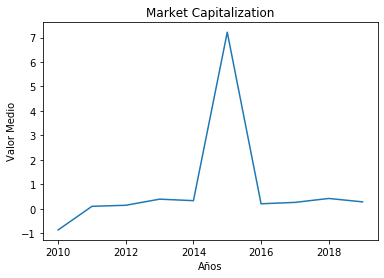

None


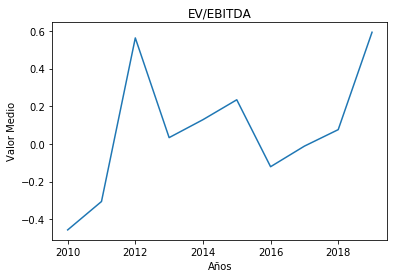

None


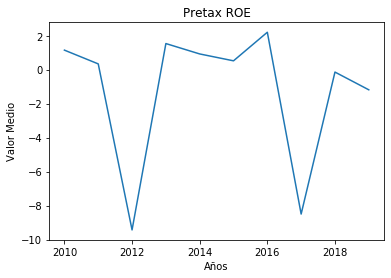

None


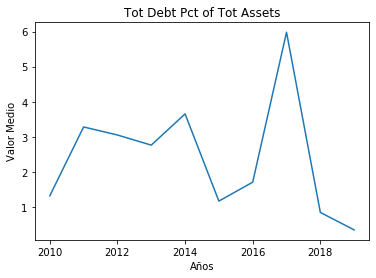

None


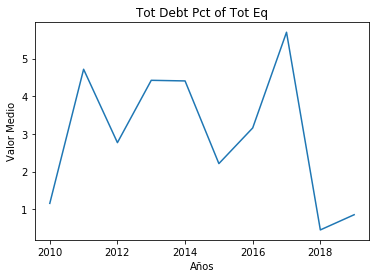

None


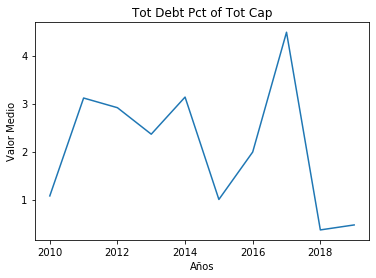

None


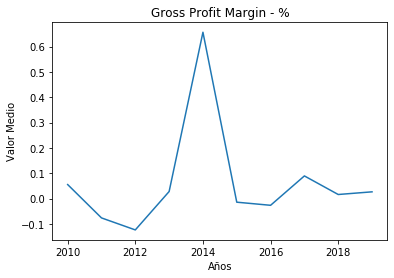

None


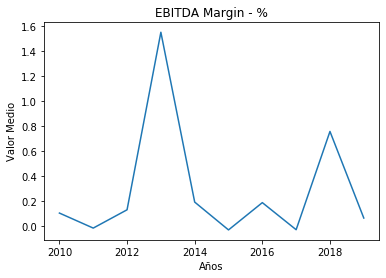

None


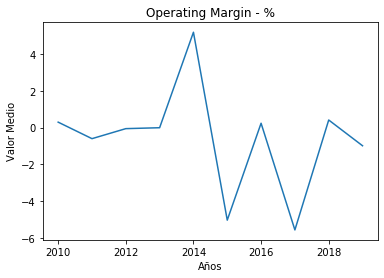

None


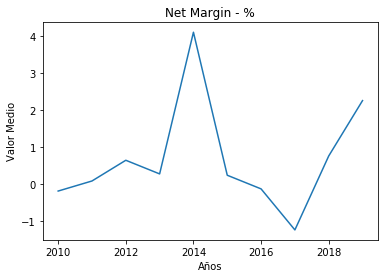

None


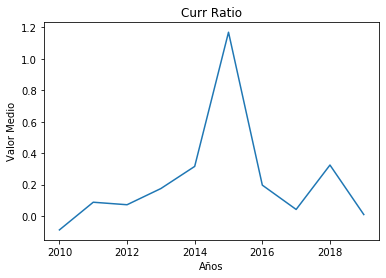

None


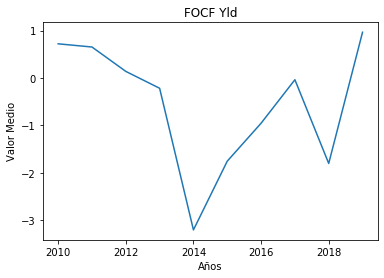

None


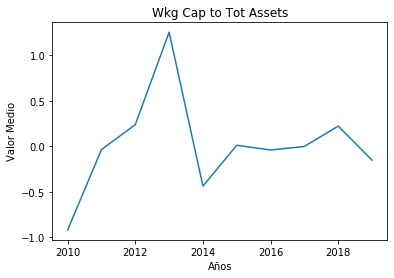

None


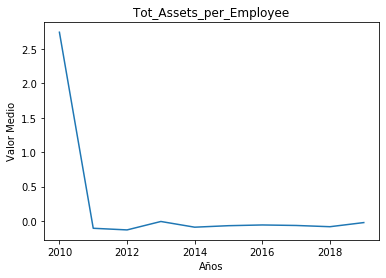

None


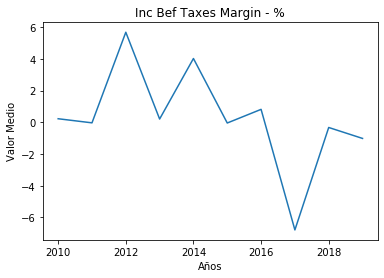

None


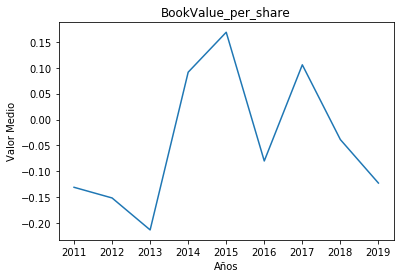

None


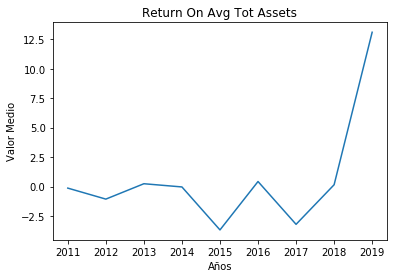

None


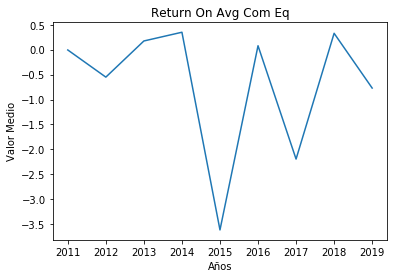

None


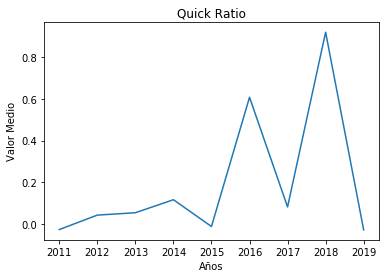

None


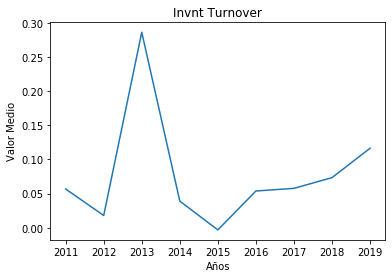

None


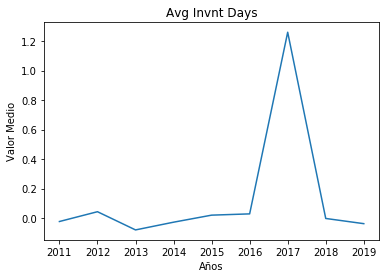

None
La matriz de correlación entre las variables es la siguiente: 



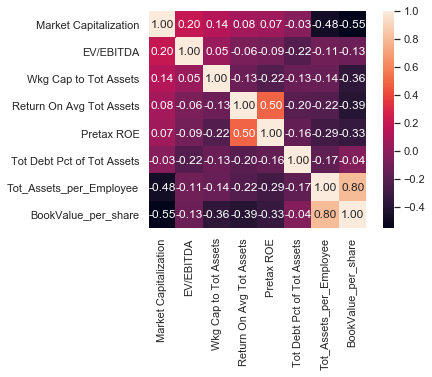

None
Las variables financieras con mayor correlación con respecto a la varianza en su cotización en la industria Software_IT_Services son las siguientes: 

BookValue_per_share
Tot_Assets_per_Employee
EV/EBITDA
Pretax ROE
Wkg Cap to Tot Assets
Return On Avg Tot Assets
Tot Debt Pct of Tot Assets
Return On Avg Com Eq
Avg Invnt Days

Los ratios financieros de esta industria han sufrido los siguientes cambios en el último año: 

                                 2019
Market Capitalization        0.278853
BookValue_per_share         -0.122515
EV/EBITDA                    0.592736
Pretax ROE                  -1.186541
Return On Avg Tot Assets    13.098434
Return On Avg Com Eq        -0.770423
Tot Debt Pct of Tot Assets   0.342968
Tot Debt Pct of Tot Eq       0.855963
Tot Debt Pct of Tot Cap      0.472204
Gross Profit Margin - %      0.026478
EBITDA Margin - %            0.064721
Operating Margin - %        -0.984057
Net Margin - %               2.258696
Quick Ratio                 -0.027176
Cu

In [8]:
analysis_empresa("Facebook")